In [1]:
import os
import datetime
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow.keras import Input, Model
from tensorflow.keras.layers import Dense, Conv2D, concatenate, Add
from tensorflow.keras.layers import Conv2DTranspose, BatchNormalization, MaxPooling2D
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.backend import binary_crossentropy

#!rm -rf ./logs/

%load_ext tensorboard
%load_ext pycodestyle_magic

IMAGE_PX = 128
BATCH_SIZE = 32
STEPS_PER_EPOCH = 50
EPOCHS = 1
LEARNING_RATE = 1e-3

In [2]:
%flake8_on --max_line_length 115
def process_path(a_path):
    def prepare_image(path, channels):
        res = tf.image.decode_png(tf.io.read_file(path), channels=channels)
        res = tf.image.convert_image_dtype(res, tf.float32)
        return tf.image.resize(res, [IMAGE_PX, IMAGE_PX])

    b_path = tf.strings.regex_replace(a_path, '/A/', '/B/')
    label_path = tf.strings.regex_replace(a_path, '/A/', '/label/')
    
    return (concatenate([prepare_image(a_path, 3),
                         prepare_image(b_path, 3)], axis=2),
            prepare_image(label_path, 1))


def deconcatenate(x):
    return x[:, :, :, 0:3], x[:, :, :, 3:6]


def preview(x, label):
    a, b = deconcatenate(x)
    label = tf.squeeze(label)
    plt.figure(figsize=(15, 45))
    plt.subplot(1, 3, 1)
    plt.imshow(a)
    plt.subplot(1, 3, 2)
    plt.imshow(b)
    plt.subplot(1, 3, 3)
    plt.imshow(label)

def prepare_for_training(ds, cache=True, shuffle_buffer_size=1000):
    if cache:
        if isinstance(cache, str):
            ds = ds.cache(cache)
        else:
            ds = ds.cache()
    ds = ds.shuffle(buffer_size=shuffle_buffer_size)

    ds = ds.repeat()

    ds = ds.batch(BATCH_SIZE)

    ds = ds.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

    return ds


def dice_coef_loss(y_true, y_pred, smooth=1, weight=0.5):
    y_true = tf.squeeze(y_true)
    y_pred = tf.squeeze(y_pred)
    intersection = tf.reduce_sum(y_true * y_pred)
    union = tf.reduce_sum(y_true) + weight * tf.reduce_sum(y_pred)
    return 1 - ((2. * intersection + smooth) / (union + smooth))


def weighted_bce_dice_loss(y_true, y_pred):
    class_loglosses = tf.reduce_mean(binary_crossentropy(y_true, y_pred),
                                     axis=[0, 1, 2])

    class_weights = [0.1, 0.9]
    weighted_bce = tf.reduce_sum(class_loglosses * class_weights)
    return weighted_bce + 0.5 * (dice_coef_loss(y_true, y_pred))


def standard_unit(input_tensor, stage, nb_filter, kernel_size=3, mode='None'):
    x = Conv2D(nb_filter,
               (kernel_size, kernel_size),
               activation='selu',
               name='conv' + stage + '_1',
               kernel_initializer='he_normal',
               padding='same',
               kernel_regularizer=l2(1e-4))(input_tensor)
    x0 = x
    x = BatchNormalization(name='bn' + stage + '_1')(x)
    x = Conv2D(nb_filter,
               (kernel_size, kernel_size),
               activation='selu',
               name='conv' + stage + '_2',
               kernel_initializer='he_normal',
               padding='same',
               kernel_regularizer=l2(1e-4))(x)
    x = BatchNormalization(name='bn' + stage + '_2')(x)
    if mode == 'residual':
        x = Add(name='resi' + stage)([x, x0])
    return x

In [3]:
def Nest_Net2(input_shape, num_class=1, deep_supervision=False):
    # nb_filter = [16, 32, 64, 128, 256]
    nb_filter = [32, 64, 128, 256, 512]
    mode = 'residual'
    bn_axis = 3

    inputs = Input(shape=input_shape)
    conv1_1 = standard_unit(inputs, stage='11', nb_filter=nb_filter[0])
    pool1 = MaxPooling2D((2, 2), strides=(2, 2), name='pool1')(conv1_1)

    conv2_1 = standard_unit(pool1, stage='21', nb_filter=nb_filter[1], mode=mode)
    pool2 = MaxPooling2D((2, 2), strides=(2, 2), name='pool2')(conv2_1)

    up1_2 = Conv2DTranspose(nb_filter[0], (2, 2), strides=(2, 2), name='up12', padding='same')(conv2_1)
    conv1_2 = concatenate([up1_2, conv1_1], name='merge12', axis=bn_axis)
    conv1_2 = standard_unit(conv1_2, stage='12', nb_filter=nb_filter[0], mode=mode)

    conv3_1 = standard_unit(pool2, stage='31', nb_filter=nb_filter[2], mode=mode)
    pool3 = MaxPooling2D((2, 2), strides=(2, 2), name='pool3')(conv3_1)

    up2_2 = Conv2DTranspose(nb_filter[1], (2, 2), strides=(2, 2), name='up22', padding='same')(conv3_1)
    conv2_2 = concatenate([up2_2, conv2_1], name='merge22', axis=bn_axis)
    conv2_2 = standard_unit(conv2_2, stage='22', nb_filter=nb_filter[1], mode=mode)

    up1_3 = Conv2DTranspose(nb_filter[0], (2, 2), strides=(2, 2), name='up13', padding='same')(conv2_2)
    conv1_3 = concatenate([up1_3, conv1_1, conv1_2], name='merge13', axis=bn_axis)
    conv1_3 = standard_unit(conv1_3, stage='13', nb_filter=nb_filter[0], mode=mode)

    conv4_1 = standard_unit(pool3, stage='41', nb_filter=nb_filter[3], mode=mode)
    pool4 = MaxPooling2D((2, 2), strides=(2, 2), name='pool4')(conv4_1)

    up3_2 = Conv2DTranspose(nb_filter[2], (2, 2), strides=(2, 2), name='up32', padding='same')(conv4_1)
    conv3_2 = concatenate([up3_2, conv3_1], name='merge32', axis=bn_axis)
    conv3_2 = standard_unit(conv3_2, stage='32', nb_filter=nb_filter[2], mode=mode)

    up2_3 = Conv2DTranspose(nb_filter[1], (2, 2), strides=(2, 2), name='up23', padding='same')(conv3_2)
    conv2_3 = concatenate([up2_3, conv2_1, conv2_2], name='merge23', axis=bn_axis)
    conv2_3 = standard_unit(conv2_3, stage='23', nb_filter=nb_filter[1], mode=mode)

    up1_4 = Conv2DTranspose(nb_filter[0], (2, 2), strides=(2, 2), name='up14', padding='same')(conv2_3)
    conv1_4 = concatenate([up1_4, conv1_1, conv1_2, conv1_3], name='merge14', axis=bn_axis)
    conv1_4 = standard_unit(conv1_4, stage='14', nb_filter=nb_filter[0], mode=mode)

    conv5_1 = standard_unit(pool4, stage='51', nb_filter=nb_filter[4], mode=mode)

    up4_2 = Conv2DTranspose(nb_filter[3], (2, 2), strides=(2, 2), name='up42', padding='same')(conv5_1)
    conv4_2 = concatenate([up4_2, conv4_1], name='merge42', axis=bn_axis)
    conv4_2 = standard_unit(conv4_2, stage='42', nb_filter=nb_filter[3], mode=mode)

    up3_3 = Conv2DTranspose(nb_filter[2], (2, 2), strides=(2, 2), name='up33', padding='same')(conv4_2)
    conv3_3 = concatenate([up3_3, conv3_1, conv3_2], name='merge33', axis=bn_axis)
    conv3_3 = standard_unit(conv3_3, stage='33', nb_filter=nb_filter[2], mode=mode)

    up2_4 = Conv2DTranspose(nb_filter[1], (2, 2), strides=(2, 2), name='up24', padding='same')(conv3_3)
    conv2_4 = concatenate([up2_4, conv2_1, conv2_2, conv2_3], name='merge24', axis=bn_axis)
    conv2_4 = standard_unit(conv2_4, stage='24', nb_filter=nb_filter[1], mode=mode)

    up1_5 = Conv2DTranspose(nb_filter[0], (2, 2), strides=(2, 2), name='up15', padding='same')(conv2_4)
    conv1_5 = concatenate([up1_5, conv1_1, conv1_2, conv1_3, conv1_4], name='merge15', axis=bn_axis)
    conv1_5 = standard_unit(conv1_5, stage='15', nb_filter=nb_filter[0], mode=mode)

    nestnet_output_1 = Conv2D(num_class, (1, 1), activation='sigmoid', name='output_1',
                              kernel_initializer='he_normal', padding='same', kernel_regularizer=l2(1e-4))(conv1_2)
    nestnet_output_2 = Conv2D(num_class, (1, 1), activation='sigmoid', name='output_2',
                              kernel_initializer='he_normal', padding='same', kernel_regularizer=l2(1e-4))(conv1_3)
    nestnet_output_3 = Conv2D(num_class, (1, 1), activation='sigmoid', name='output_3',
                              kernel_initializer='he_normal', padding='same', kernel_regularizer=l2(1e-4))(conv1_4)
    nestnet_output_4 = Conv2D(num_class, (1, 1), activation='sigmoid', name='output_4',
                              kernel_initializer='he_normal', padding='same', kernel_regularizer=l2(1e-4))(conv1_5)
    # using combined loss
    conv_fuse = concatenate([conv1_2, conv1_3, conv1_4, conv1_5], name='merge_fuse', axis=bn_axis)
    nestnet_output_5 = Conv2D(num_class, (1, 1),
                              activation='sigmoid', name='output_5',
                              kernel_initializer='he_normal', padding='same',
                              kernel_regularizer=l2(1e-4))(conv_fuse)

    if deep_supervision:
        model = Model(inputs=inputs, outputs=[nestnet_output_1,
                                              nestnet_output_2,
                                              nestnet_output_3,
                                              nestnet_output_4,
                                              nestnet_output_5])
        model.compile(optimizer=Adam(lr=LEARNING_RATE),
                      loss=[weighted_bce_dice_loss,
                            weighted_bce_dice_loss,
                            weighted_bce_dice_loss,
                            weighted_bce_dice_loss,
                            weighted_bce_dice_loss],
                      loss_weights=[0.5, 0.5, 0.75, 0.5, 1.0],
                      metrics=['accuracy']
                      )
    else:
        model = Model(inputs=inputs, outputs=[nestnet_output_4])
        model.compile(optimizer=Adam(lr=LEARNING_RATE),
                      loss=weighted_bce_dice_loss,
                      metrics=['accuracy'])

    model.summary()
    return model

In [4]:
base_path = './LEVIR-CD/'

train_path_list = tf.data.Dataset.list_files(base_path + 'train/A/*.png')
test_path_list = tf.data.Dataset.list_files(base_path + 'test/A/*.png')
val_path_list = tf.data.Dataset.list_files(base_path + 'val/A/*.png')

train_ds = train_path_list.map(process_path, num_parallel_calls=tf.data.experimental.AUTOTUNE)
test_ds = test_path_list.map(process_path, num_parallel_calls=tf.data.experimental.AUTOTUNE)
val_ds = val_path_list.map(process_path, num_parallel_calls=tf.data.experimental.AUTOTUNE)

In [5]:
checkpoint_path = "./checkpoints/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                         save_weights_only=True,
                                                         save_best_only=True,
                                                         monitor='accuracy',
                                                         mode='max',
                                                         verbose=0,
                                                         save_freq='epoch')

In [6]:
input_shape = [IMAGE_PX, IMAGE_PX, 6]
model = Nest_Net2(input_shape, deep_supervision=False)

train_ds = prepare_for_training(train_ds)
val_ds = val_ds.batch(BATCH_SIZE)
test_ds = test_ds.batch(BATCH_SIZE)

log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

try:
    model.load_weights(tf.train.latest_checkpoint(checkpoint_dir))
except AttributeError:
    pass

model.fit(train_ds,
          steps_per_epoch=STEPS_PER_EPOCH,
          epochs=EPOCHS,
          validation_data=val_ds,
          callbacks=[tensorboard_callback, checkpoint_callback])

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 6) 0                                            
__________________________________________________________________________________________________
conv11_1 (Conv2D)               (None, 128, 128, 32) 1760        input_1[0][0]                    
__________________________________________________________________________________________________
bn11_1 (BatchNormalization)     (None, 128, 128, 32) 128         conv11_1[0][0]                   
__________________________________________________________________________________________________
conv11_2 (Conv2D)               (None, 128, 128, 32) 9248        bn11_1[0][0]                     
______________________________________________________________________________________________

In [7]:
def target_dim(channels):
    return [1, IMAGE_PX, IMAGE_PX, channels]


x, label = next(iter(test_ds.take(1)))
a, b = deconcatenate(x)
raw_pred = model.predict(x)
if isinstance(raw_pred, list):
    raw_pred = raw_pred[-1]
bool_pred = tf.cast(tf.greater_equal(raw_pred, 0.6), tf.float32)

file_writer = tf.summary.create_file_writer(log_dir)
for i in range(BATCH_SIZE):
    with file_writer.as_default():
        tf.summary.image("Image {} A".format(i + 1), tf.reshape(a[i, :, :, :], target_dim(3)), step=0)
        tf.summary.image("Image {} B".format(i + 1), tf.reshape(b[i, :, :, :], target_dim(3)), step=0)
        tf.summary.image("Image {} Groundtruth".format(i + 1), tf.reshape(label[i], target_dim(1)), step=0)
        tf.summary.image("Image {} Raw Prediction".format(i + 1), tf.reshape(raw_pred[i], target_dim(1)), step=0)
        tf.summary.image("Image {} Boolean Prediction".format(i + 1), tf.reshape(bool_pred[i], target_dim(1)), step=0)

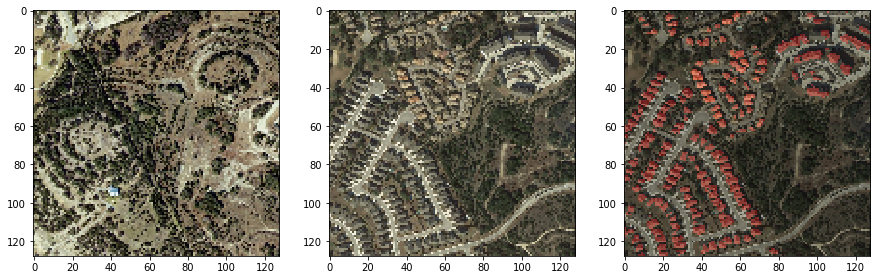

In [8]:
index = 18

a, b = deconcatenate(x)
a = x[:, :, :, 0:3]
b = x[:, :, :, 3:6]

raw_pred_c = tf.image.grayscale_to_rgb(tf.constant(raw_pred[index, :, :])).numpy()
raw_pred_c[:, :, 1] = 0
raw_pred_c[:, :, 2] = 0

bool_pred_c = tf.image.grayscale_to_rgb(bool_pred[index, :, :]).numpy()
bool_pred_c[:, :, 1] = 0
bool_pred_c[:, :, 2] = 0

plt.figure(figsize=(15, 45))

plt.subplot(131)
plt.imshow(a[index, :, :, :])


plt.subplot(132)
plt.imshow(b[index, :, :, :])

plt.subplot(133)
plt.imshow(b[index, :, :, :], interpolation='nearest', alpha=1)
plt.imshow(bool_pred_c, interpolation='nearest', alpha=0.3)

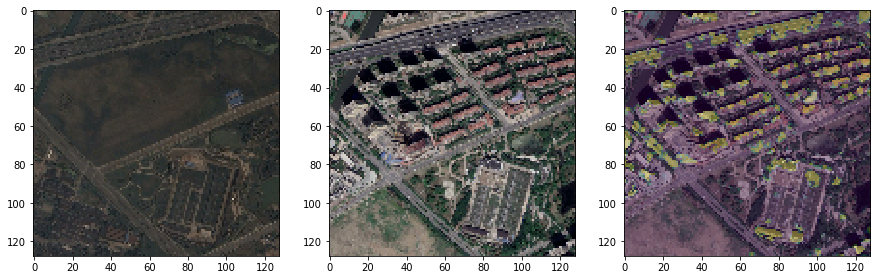

In [9]:
a_path = './test_set/Before.png'
b_path = './test_set/After.png'


def prepare_image(path, channels):
    res = tf.image.decode_png(tf.io.read_file(path), channels=channels)
    res = tf.image.convert_image_dtype(res, tf.float32)
    return tf.image.resize(res, [IMAGE_PX, IMAGE_PX])


a = prepare_image(a_path, 3)
b = prepare_image(b_path, 3)

x = concatenate([a, b], axis=2)

x = x[tf.newaxis, ...]

predd = tf.squeeze(model.predict(x)[0])

plt.figure(figsize=(15, 45))

plt.subplot(131)
plt.imshow(a)


plt.subplot(132)
plt.imshow(b)

plt.subplot(133)
plt.imshow(b, interpolation='nearest', alpha=1)
plt.imshow(predd, interpolation='nearest', alpha=0.3)